In [63]:
# from tensorflow.python.client import device_lib
# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']
# get_available_gpus()

[]

In [2]:
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
import os.path
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import seaborn as sns
# import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Dense, Flatten, LSTM, Dropout
from tensorflow.keras import initializers
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix

import gzip
import pickle

### Load data (not yet split)

In [18]:
fname = "dataset_hmx_20210106T180157_raw_filtered_baselineSubtracted_thres100_fp1fp2_1000points_500Hz.pkl"
f = open(os.path.join(r"..\data\data2", fname), 'rb')
data, labels = pickle.load(f)
f.close()

print(data.shape)
print(labels.shape)

(857, 2, 1000)
(857,)


### Split the dataset

In [19]:
data, labels = shuffle(data, labels)

In [20]:
total_samples = data.shape[0]
trn, tst, vld = list(map(int, [0.6*total_samples, 
                               0.1*total_samples, 
                               0.3*total_samples]))
print(trn, tst, vld)
      
train_images = data[:trn, :, :]
train_labels = labels[:trn,]

test_images = data[trn:trn + tst, :, :]
test_labels = labels[trn:trn + tst,]

valid_images = data[trn + tst:trn + tst + vld, :, :]
valid_labels = labels[trn + tst:trn + tst + vld,]

514 85 257


In [21]:
from collections import Counter
d = Counter(train_labels)
print(d)
d = Counter(test_labels)
print(d)
d = Counter(valid_labels)
print(d)

Counter({2: 177, 0: 173, 1: 164})
Counter({1: 41, 0: 27, 2: 17})
Counter({2: 91, 0: 87, 1: 79})


In [22]:
print(train_images.shape)
print(test_images.shape)
print(valid_images.shape)

print(train_labels[1:10])

print(train_labels.shape)
print(test_labels.shape)
print(valid_labels.shape)

(514, 2, 1000)
(85, 2, 1000)
(257, 2, 1000)
[0 2 1 1 1 2 1 1 2]
(514,)
(85,)
(257,)


In [23]:
# # For 1D data only
# train_images = np.squeeze(train_images)
# test_images = np.squeeze(test_images)
# valid_images = np.squeeze(valid_images)

# print(train_images.shape)
# print(test_images.shape)
# fname = "attention_f16_1301.pkl"
# f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
# data, labels = pickle.load(f)
# f.close()

# print(data.shape)
# print(labels.shape)print(valid_images.shape)

In [24]:
dataset = [train_images, test_images, valid_images, train_labels, test_labels, valid_labels]

### View the data

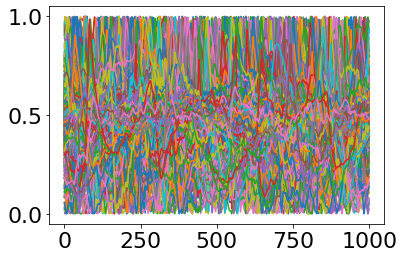

In [25]:
plt.figure()
for k in range(train_images.shape[0]):
    for i in range(train_images.shape[1]):
        plt.plot(train_images[k][i])

In [12]:
# sampling = [0,100,200]
# for i in sampling:
#     plt.plot(train_images[i][0])

# CNN

In [26]:
# Reshape the images. Only when using Conv2D and MaxPooling2D
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)
valid_images = np.expand_dims(valid_images, axis=3)

print(train_images.shape)
print(train_labels.shape)

(514, 2, 1000, 1)
(514,)


In [27]:
test_labels[0:10]

array([0, 1, 0, 1, 2, 0, 1, 1, 1, 2])

In [31]:
# # Build the model.

# model_cnn = Sequential()

# model_cnn.add(Conv1D(32,100,input_shape=(2, 1000, 1),activation='relu'))
# model_cnn.add(MaxPooling2D(pool_size=(1,3)))

# model_cnn.add(Conv1D(64,50,activation='relu'))
# model_cnn.add(MaxPooling2D(pool_size=(1,2)))

# # new layer
# model_cnn.add(Conv1D(128,50,activation='relu'))
# model_cnn.add(Conv1D(32,25,activation='relu'))
# model_cnn.add(MaxPooling2D(pool_size=(1,2)))

# model_cnn.add(Flatten())
# model_cnn.add(Dropout(0.5))

# model_cnn.add(Dense(1024,activation='relu'))
# model_cnn.add(Dense(2,activation='softmax'))
# model_cnn.summary()

# # Build the model.

# model_cnn = Sequential()

# model_cnn.add(Conv1D(16,100,input_shape=(2, 1000, 1),activation='relu'))
# model_cnn.add(MaxPooling2D(pool_size=(1,3)))

# model_cnn.add(Conv1D(32,50,activation='relu'))
# model_cnn.add(MaxPooling2D(pool_size=(1,2)))

# model_cnn.add(Flatten())
# model_cnn.add(Dropout(0.5))

# model_cnn.add(Dense(1024,activation='relu'))
# model_cnn.add(Dense(3, activation='softmax'))
# model_cnn.summary()

# Build the model.

model_cnn = Sequential()

model_cnn.add(Conv1D(16,100,input_shape=(2, 1000, 1),activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(1,3)))

model_cnn.add(Conv1D(32,50,activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(1,2)))

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(1024,activation='relu'))
model_cnn.add(Dense(3, activation='softmax'))
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 2, 901, 16)        1616      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 300, 16)        0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 251, 32)        25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 125, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)             

In [33]:
# Compile the model.

# Chnage the learning rate decay to prevent the acc from stucking at 50.00%
# as is mentioned in https://github.com/keras-team/keras/issues/1597
from tensorflow.keras import optimizers
op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.001, amsgrad=False)


model_cnn.compile(
  optimizer='SGD',
  loss='categorical_crossentropy',
  metrics=['acc'],
)

from keras import backend as K
K.set_value(model_cnn.optimizer.learning_rate, 0.005)

# Train the model.
history_cnn = model_cnn.fit(
    train_images,
    to_categorical(train_labels),
    batch_size=8,
    epochs=200,
    validation_data=(test_images, to_categorical(test_labels)),
)

Epoch 1/200
65/65 [==============================] - 4s 61ms/step - loss: 0.6338 - acc: 0.7393 - val_loss: 1.9546 - val_acc: 0.2824
Epoch 2/200
65/65 [==============================] - 4s 58ms/step - loss: 0.6116 - acc: 0.7510 - val_loss: 1.7087 - val_acc: 0.3529
Epoch 3/200
65/65 [==============================] - 4s 59ms/step - loss: 0.5801 - acc: 0.7529 - val_loss: 2.0091 - val_acc: 0.3412
Epoch 4/200
65/65 [==============================] - 4s 63ms/step - loss: 0.5668 - acc: 0.7568 - val_loss: 2.4535 - val_acc: 0.3059
Epoch 5/200
65/65 [==============================] - 4s 63ms/step - loss: 0.5512 - acc: 0.7821 - val_loss: 2.0645 - val_acc: 0.2706
Epoch 6/200
65/65 [==============================] - 4s 62ms/step - loss: 0.5485 - acc: 0.7763 - val_loss: 1.9017 - val_acc: 0.3765
Epoch 7/200
65/65 [==============================] - 4s 63ms/step - loss: 0.4789 - acc: 0.7996 - val_loss: 1.8404 - val_acc: 0.3765
Epoch 8/200
65/65 [==============================] - 4s 62ms/step - loss: 0.

65/65 [==============================] - 4s 62ms/step - loss: 0.0557 - acc: 0.9864 - val_loss: 4.4902 - val_acc: 0.4000
Epoch 63/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0523 - acc: 0.9844 - val_loss: 4.6289 - val_acc: 0.3765
Epoch 64/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0587 - acc: 0.9844 - val_loss: 4.2417 - val_acc: 0.3765
Epoch 65/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0348 - acc: 0.9961 - val_loss: 4.5156 - val_acc: 0.3647
Epoch 66/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0441 - acc: 0.9903 - val_loss: 5.3285 - val_acc: 0.3529
Epoch 67/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0633 - acc: 0.9883 - val_loss: 4.5989 - val_acc: 0.3882
Epoch 68/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0416 - acc: 0.9903 - val_loss: 4.8244 - val_acc: 0.4235
Epoch 69/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0614 

65/65 [==============================] - 4s 62ms/step - loss: 0.0353 - acc: 0.9903 - val_loss: 6.0258 - val_acc: 0.4000
Epoch 124/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0191 - acc: 0.9961 - val_loss: 6.3226 - val_acc: 0.3294
Epoch 125/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0226 - acc: 0.9961 - val_loss: 6.1441 - val_acc: 0.3412
Epoch 126/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0134 - acc: 0.9961 - val_loss: 6.2070 - val_acc: 0.3765
Epoch 127/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0108 - acc: 0.9981 - val_loss: 5.8668 - val_acc: 0.4000
Epoch 128/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0127 - acc: 0.9961 - val_loss: 5.5519 - val_acc: 0.4000
Epoch 129/200
65/65 [==============================] - 4s 61ms/step - loss: 0.0359 - acc: 0.9942 - val_loss: 5.7305 - val_acc: 0.3882
Epoch 130/200
65/65 [==============================] - 4s 62ms/step - loss: 

65/65 [==============================] - 4s 62ms/step - loss: 0.0104 - acc: 0.9961 - val_loss: 6.3522 - val_acc: 0.3765
Epoch 185/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0071 - acc: 0.9981 - val_loss: 6.5792 - val_acc: 0.3765
Epoch 186/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0098 - acc: 0.9961 - val_loss: 7.0902 - val_acc: 0.3412
Epoch 187/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 7.0217 - val_acc: 0.3529
Epoch 188/200
65/65 [==============================] - 4s 62ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 7.1453 - val_acc: 0.3412
Epoch 189/200
65/65 [==============================] - 4s 67ms/step - loss: 0.0113 - acc: 0.9942 - val_loss: 6.5533 - val_acc: 0.3529
Epoch 190/200
65/65 [==============================] - 4s 64ms/step - loss: 0.0185 - acc: 0.9903 - val_loss: 6.3676 - val_acc: 0.3882
Epoch 191/200
65/65 [==============================] - 4s 66ms/step - loss: 

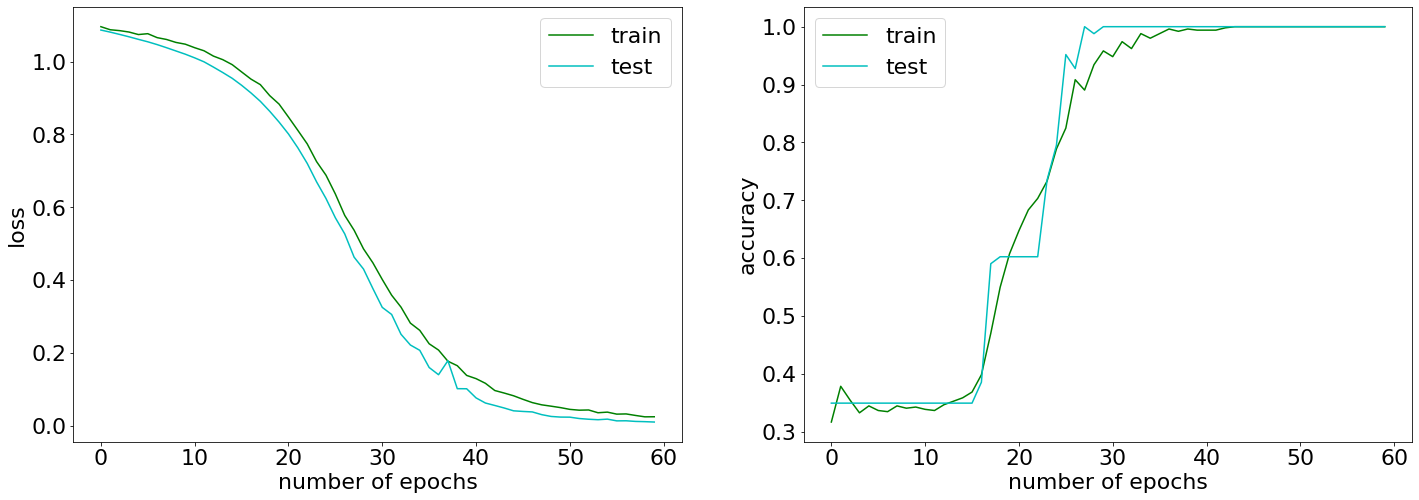

In [20]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
nepochs = len(history_cnn.history['loss'])
plt.plot(range(nepochs), history_cnn.history['loss'], 'g-', label='train')
plt.plot(range(nepochs), history_cnn.history['val_loss'], 'c-', label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('number of epochs')

plt.subplot(1,2,2)
nepochs = len(history_cnn.history['acc'])
plt.plot(range(nepochs), history_cnn.history['acc'], 'g-', label='train')
plt.plot(range(nepochs), history_cnn.history['val_acc'], 'c-', label='test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('number of epochs')

plt.savefig(r"..\data\data3_attention\fig\cnn_attention_f16_1301.jpg")

In [57]:
# Save the model to disk.
model_cnn.save_weights('..\data\data3_attention\cnn_attention_binary_0006.h5')

# Batch process

In [22]:
def run_pipeline(fname):
    
    print("===============================================")
    print("------Run:", fname)
    exclude = fname.split('.')[0][-4:]
    print("------Test Subject #", exclude, " using a model trained by data of all other subjects.")
    
    f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
    data, labels = pickle.load(f)
    f.close()
    print("data shape:   ", data.shape)
    print("labels shape: ", labels.shape)
    data, labels = shuffle(data, labels)
    print("------Shuffled.")

    total_samples = data.shape[0]
    trn, tst, vld = list(map(int, [0.6*total_samples, 
                                   0.1*total_samples, 
                                   0.3*total_samples]))
    print(trn, tst, vld)

    train_images = data[:trn, :, :]
    train_labels = labels[:trn,]
    test_images  = data[trn:trn + tst, :, :]
    test_labels  = labels[trn:trn + tst,]
    valid_images = data[trn + tst:trn + tst + vld, :, :]
    valid_labels = labels[trn + tst:trn + tst + vld,]

    print("------Check distribution:")
    from collections import Counter
    d = Counter(train_labels)
    print("Train:", d)
    d = Counter(test_labels)
    print("Valid:", d)

    print("------Print shape:")

    # Reshape the images. Only when using Conv2D and MaxPooling2D
    train_images = np.expand_dims(train_images, axis=3)
    test_images = np.expand_dims(test_images, axis=3)
    valid_images = np.expand_dims(valid_images, axis=3)

    print(train_images.shape)
    print(test_images.shape)
    print(valid_images.shape)

    print(train_labels[1:10])

    print(train_labels.shape)
    print(test_labels.shape)
    print(valid_labels.shape)


    print("------Build the model:")
    model_cnn = Sequential()

    model_cnn.add(Conv1D(16,100,input_shape=(2, 1000, 1),activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1,3)))

    model_cnn.add(Conv1D(32,50,activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1,2)))

    model_cnn.add(Flatten())
    model_cnn.add(Dropout(0.5))

    model_cnn.add(Dense(512,activation='relu'))
    model_cnn.add(Dense(3, activation='softmax'))
    model_cnn.summary()

    # Compile the model.
    print("------Compile the model.")
    from tensorflow.keras import optimizers
    op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.001, amsgrad=False)

    model_cnn.compile(
      optimizer='SGD',
      loss='categorical_crossentropy',
      metrics=['acc'],
    )

    print("------Train the model:")
    history_cnn = model_cnn.fit(
        train_images,
        to_categorical(train_labels),
        batch_size=10,
        epochs=60,
        validation_data=(test_images, to_categorical(test_labels)),
    )


    plt.figure(figsize=(24,8))

    plt.subplot(1,2,1)
    nepochs = len(history_cnn.history['loss'])
    plt.plot(range(nepochs), history_cnn.history['loss'], 'g-', label='train')
    plt.plot(range(nepochs), history_cnn.history['val_loss'], 'c-', label='test')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('number of epochs')

    plt.subplot(1,2,2)
    nepochs = len(history_cnn.history['acc'])
    plt.plot(range(nepochs), history_cnn.history['acc'], 'g-', label='train')
    plt.plot(range(nepochs), history_cnn.history['val_acc'], 'c-', label='test')
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('number of epochs')

    plt.savefig(r"..\data\data3_attention\fig\cnn_attention_f16_"+exclude+".jpg")
    
    
    print("------Test the model on its test set:")
    pred_prob = model_cnn.predict(valid_images)
    pred_labels = []
    for encode in pred_prob:
        category = np.where(encode==np.amax(encode))[0][0]
        pred_labels.append(category)
    pred_labels = np.array(pred_labels)

    classes = [0,1,2]
    # argmax: reverse the to_categorical operation
    con_mat = confusion_matrix(valid_labels, predictions=pred_labels).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)
    figure = plt.figure(figsize=(4,4))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    truecases = con_mat[0][0] + con_mat[1][1] + con_mat[2][2]
    totalcases = len(pred_labels)


    print("Accuracy:", truecases/totalcases)
    print("Confusion matrix:")
    for i in con_mat:
        print(i)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(r"..\data\data3_attention\fig\cnn_attention_f16_"+exclude+"_selftest.jpg")

    # Save the model to disk.
    model_cnn.save_weights(r"..\data\data3_attention\cnn_attention_f16_"+exclude+".h5")

    
    print("------Test the model on the excluded subject:")
    tname = "attention_"+exclude+"_low_fp1fp2_2s_resampled500Hz.pkl"
    f = open(os.path.join(r"..\data\data3_attention", tname), 'rb')
    data1, labels1 = pickle.load(f)
    f.close()

    data1, labels1 = shuffle(data1, labels1)

    total_samples1 = data1.shape[0]
    trn1, tst1, vld1 = list(map(int, [0*total_samples1, 
                                   0*total_samples1, 
                                   1*total_samples1]))

    valid_images1 = data1[trn1 + tst1:trn1 + tst1 + vld1, :, :]
    valid_labels1 = labels1[trn1 + tst1:trn1 + tst1 + vld1,]
    valid_images1 = np.expand_dims(valid_images1, axis=3)

    print(valid_images1.shape)
    print(valid_labels1.shape)
    
    # Predict.
    pred_prob1 = model_cnn.predict(valid_images1)
    pred_labels1 = []
    for encode in pred_prob1:
        category = np.where(encode==np.amax(encode))[0][0]
        pred_labels1.append(category)
    pred_labels1 = np.array(pred_labels1)

    classes = [0,1,2]
    # argmax: reverse the to_categorical operation
    con_mat1 = confusion_matrix(valid_labels1, predictions=pred_labels1).numpy()
    con_mat_norm1 = np.around(con_mat1.astype('float') / con_mat1.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df1 = pd.DataFrame(con_mat_norm1,
                         index = classes, 
                         columns = classes)
    figure = plt.figure(figsize=(4,4))
    sns.heatmap(con_mat_df1, annot=True,cmap=plt.cm.Blues)
    truecases1 = con_mat1[0][0] + con_mat1[1][1] + con_mat1[2][2]
    totalcases1 = len(pred_labels1)

    print("Accuracy:", truecases1/totalcases1)
    print("Confusion matrix:")
    for i in con_mat1:
        print(i)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(r"..\data\data3_attention\fig\cnn_attention_f16_"+exclude+"_singletest.jpg")

------Run: attention_f16_0002.pkl
------Test Subject # 0002  using a model trained by data of all other subjects.
data shape:    (12521, 2, 1000)
labels shape:  (12521,)
------Shuffled.
7512 1252 3756
------Check distribution:
Train: Counter({1: 2532, 0: 2515, 2: 2465})
Valid: Counter({0: 439, 2: 413, 1: 400})
------Print shape:
(7512, 2, 1000, 1)
(1252, 2, 1000, 1)
(3756, 2, 1000, 1)
[1 2 0 0 2 0 2 2 0]
(7512,)
(1252,)
(3756,)
------Build the model:
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 2, 901, 16)        1616      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 2, 300, 16)        0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 2, 251, 32)        25632     
____________________________________________________________

KeyboardInterrupt: 

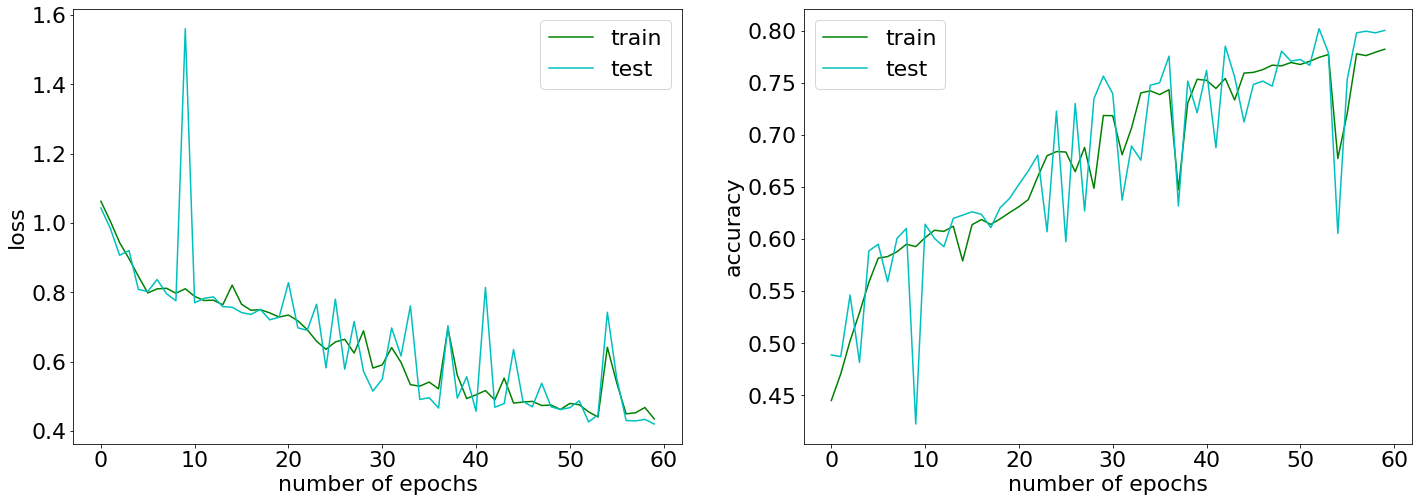

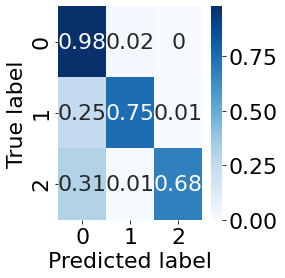

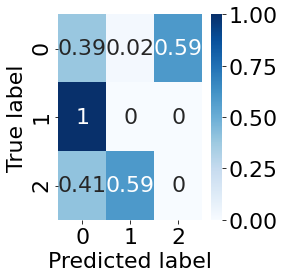

In [23]:
to_run =[
    'attention_f16_0002.pkl',
    'attention_f16_0005.pkl',
]

for fname in to_run:
    run_pipeline(fname)

# Test

In [24]:
# Load the trained model from disk
model_cnn.load_weights('..\data\data3_attention\cnn_attention_1301.h5')

In [59]:
# ================== Select your test data ==========================

fname = "attention_binary_0013_low_fp1fp2_2s_resampled500Hz.pkl"
f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
data, labels = pickle.load(f)
f.close()

print(data.shape)
print(labels.shape)

data, labels = shuffle(data, labels)

total_samples = data.shape[0]
trn, tst, vld = list(map(int, [0*total_samples, 
                               0*total_samples, 
                               1*total_samples]))
print("trn, tst, vld:", trn, tst, vld)


valid_images = data[trn + tst:trn + tst + vld, :, :]
valid_labels = labels[trn + tst:trn + tst + vld,]
valid_images = np.expand_dims(valid_images, axis=3)

valid_images = np.expand_dims(valid_images, axis=3)

print(valid_images.shape)
print(valid_labels.shape)


(558, 2, 1000)
(558,)
trn, tst, vld: 0 0 558
(558, 2, 1000, 1, 1)
(558,)


Accuracy: 0.33073929961089493
Confusion matrix:
[28 27 32]
[25 27 27]
[28 33 30]


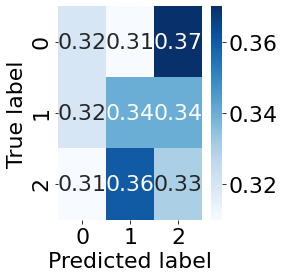

In [34]:
# Predict.
pred_prob = model_cnn.predict(valid_images)
pred_labels = []
for encode in pred_prob:
    category = np.where(encode==np.amax(encode))[0][0]
    pred_labels.append(category)
pred_labels = np.array(pred_labels)

# Triple
classes = [0,1,2]
# Binary
# classes = [0,1]
# argmax: reverse the to_categorical operation
con_mat = confusion_matrix(valid_labels, predictions=pred_labels).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(4,4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
# Triple
truecases = con_mat[0][0] + con_mat[1][1] + con_mat[2][2]
# Binary
# truecases = con_mat[0][0] + con_mat[1][1]
totalcases = len(pred_labels)


print("Accuracy:", truecases/totalcases)
print("Confusion matrix:")
for i in con_mat:
    print(i)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Cross test

In [27]:
# ================== Select your test data ==========================
def get_test_data(fname):
    f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
    data, labels = pickle.load(f)
    f.close()
    data, labels = shuffle(data, labels)

    total_samples = data.shape[0]
    trn, tst, vld = list(map(int, [0*total_samples, 
                                   0*total_samples, 
                                   0.4*total_samples]))
    print("Test samples:", vld)

    valid_images = data[trn + tst:trn + tst + vld, :, :]
    valid_labels = labels[trn + tst:trn + tst + vld,]
    valid_images = np.expand_dims(valid_images, axis=3)

    valid_images = np.expand_dims(valid_images, axis=3)

    return valid_images, valid_labels

def mypredict(valid_images):
    # Predict.
    pred_prob = model_cnn.predict(valid_images)
    pred_labels = []
    for encode in pred_prob:
        category = np.where(encode==np.amax(encode))[0][0]
        pred_labels.append(category)
    pred_labels = np.array(pred_labels)

    # Triple

#     classes = [0,1,2]
#     # argmax: reverse the to_categorical operation
    con_mat = confusion_matrix(valid_labels, predictions=pred_labels).numpy()
#     con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
#     con_mat_df = pd.DataFrame(con_mat_norm,
#                          index = classes, 
#                          columns = classes)
#     figure = plt.figure(figsize=(4,4))
#     sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    truecases = con_mat[0][0] + con_mat[1][1] + con_mat[2][2]
    totalcases = len(pred_labels)

    accuracy = truecases/totalcases
#     print("Accuracy:", truecases/totalcases)
#     print("Confusion matrix:")
#     for i in con_mat:
#         print(i)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()
    return accuracy, con_mat

In [28]:
matr = [[0]*16 for i in range(16)]
tr = 0
te = 0
subs = ['0002','0004','0005','0006','0007','0009','0013','0201',
    #    0      1      2      3      4      5      6      7
        '0401','0502','0601','0701','0801','0901','1101','1301']
    #    8      9      10     11     12     13     14     15
for train in subs:
    te = 0
    for test in subs:
        # Load the trained model from disk
        mod = '..\data\data3_attention\cnn_attention_'+train+'.h5'
        model_cnn.load_weights(mod)
        print("Model trained on: Subject #", train)
        print("Predicted on:     Subject #", test)
        valid_images, valid_labels = get_test_data("attention_"+test+"_low_fp1fp2_2s_resampled500Hz.pkl")
        accuracy, con_mat = mypredict(valid_images)
        matr[tr][te] = accuracy
        te += 1
    tr += 1

Model trained on: Subject # 0002
Predicted on:     Subject # 0002
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0004
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0005
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0006
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0007
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0009
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0013
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0201
Test samples: 329
Model trained on: Subject # 0002
Predicted on:     Subject # 0401
Test samples: 329
Model trained on: Subject # 0002
Predicted on:     Subject # 0502
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0601
Test samples: 334
Model trained on: Subject # 0002
Predicted on:     Subject # 0701
Test sampl

Model trained on: Subject # 0013
Predicted on:     Subject # 0005
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0006
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0007
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0009
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0013
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0201
Test samples: 329
Model trained on: Subject # 0013
Predicted on:     Subject # 0401
Test samples: 329
Model trained on: Subject # 0013
Predicted on:     Subject # 0502
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0601
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0701
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0801
Test samples: 334
Model trained on: Subject # 0013
Predicted on:     Subject # 0901
Test sampl

Model trained on: Subject # 0801
Predicted on:     Subject # 0007
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 0009
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 0013
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 0201
Test samples: 329
Model trained on: Subject # 0801
Predicted on:     Subject # 0401
Test samples: 329
Model trained on: Subject # 0801
Predicted on:     Subject # 0502
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 0601
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 0701
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 0801
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 0901
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 1101
Test samples: 334
Model trained on: Subject # 0801
Predicted on:     Subject # 1301
Test sampl

Text(0.5, 68.0, 'Predict set')

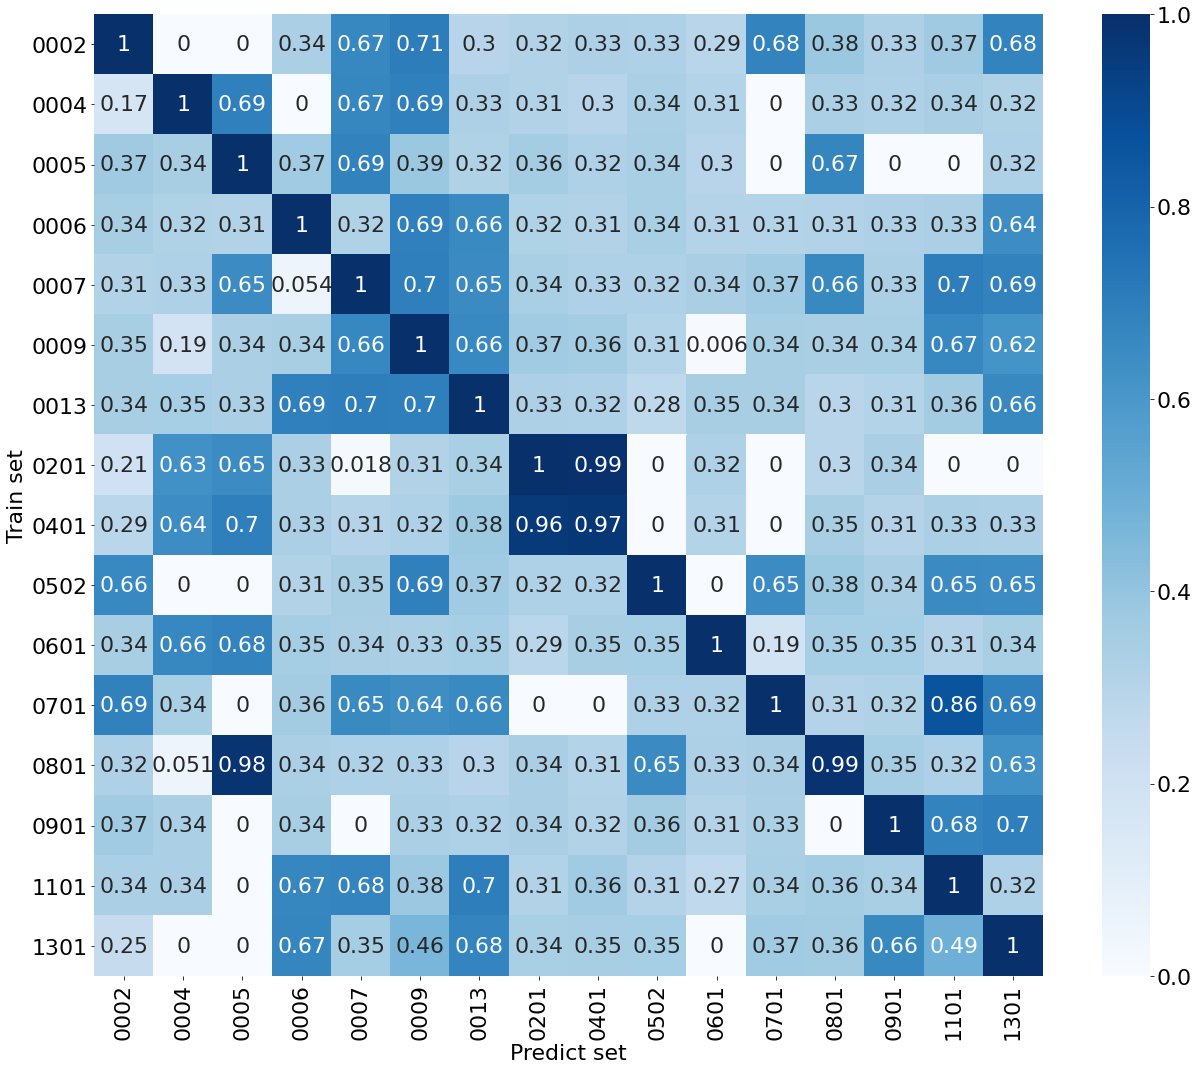

In [29]:
matr_df = pd.DataFrame(matr, index = subs, columns = subs)
figure = plt.figure(figsize=(18,15))
sns.heatmap(matr_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('Train set')
plt.xlabel('Predict set')

In [30]:
matr = np.array(matr)
np.savetxt(r"D:\GitHub\EEG_fatigue\doc\cnn_cross.csv",matr,delimiter=',')